In [1]:
# setup
import os, sys, importlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY

from regression.plotting_helpers import plot_group_box_with_pvals, plot_bias_panels_ABC, make_equal_count_age_groups, make_age_binary_groups, plot_bias_panels_AB_age2
from regression.model_evaluation_helpers import save_group_tables, adjust_pvals

# style
plt.rcParams["font.family"] = "Arial"
sns.set_theme(context="paper", style="white")

# load OOF predictions
oof_dir  = os.path.join(GIT_DIRECTORY, "results", "regression", "oof_results")
oof_path = os.path.join(oof_dir, "oof_preds_all_scores.csv")
oof_all  = pd.read_csv(oof_path)

# build Country×Gender label (lowercase inputs assumed: 'uk'/'usa' and 'f'/'m')
oof_all = oof_all.copy()
oof_all["Country_label"] = oof_all["Country_label"].str.lower()
oof_all["Gender_label"]  = oof_all["Gender_label"].str.lower()
oof_all["CountryGender_label"] = (
    oof_all["Country_label"] + "_" + oof_all["Gender_label"]
)

# inputs
model   = "full"
task    = "picnicScene"
target = "PictureNamingScore"
save_path = os.path.join(GIT_DIRECTORY, "results", "regression", "bias")

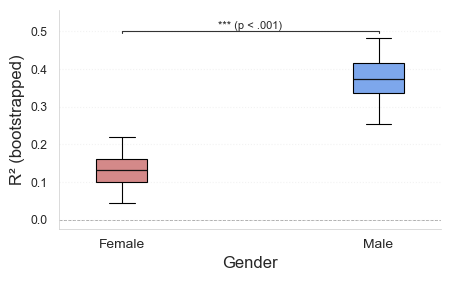

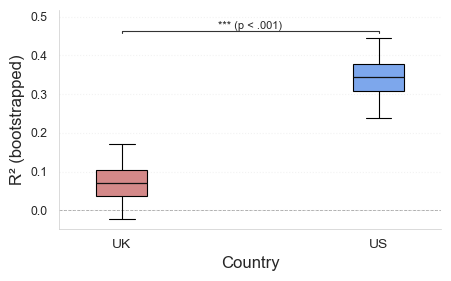

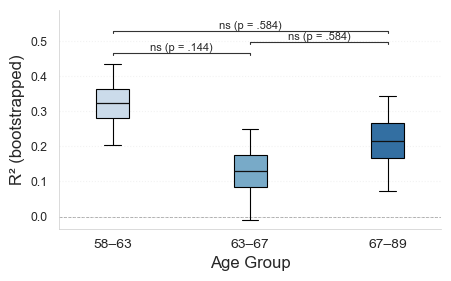

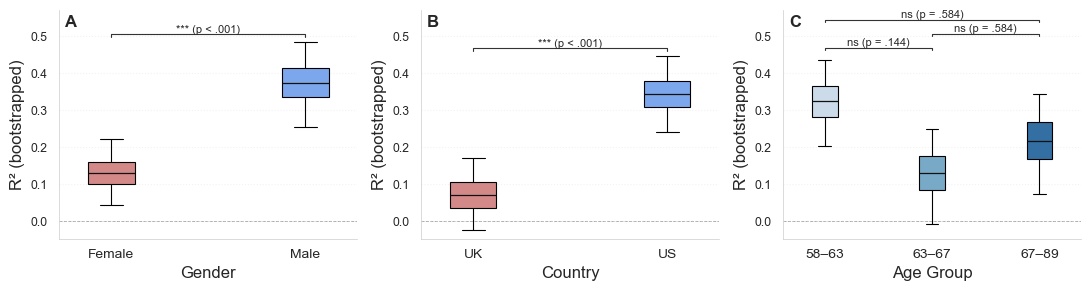

(<Figure size 1100x300 with 3 Axes>,
 array([<Axes: xlabel='Gender', ylabel='R² (bootstrapped)'>,
        <Axes: xlabel='Country', ylabel='R² (bootstrapped)'>,
        <Axes: xlabel='Age Group', ylabel='R² (bootstrapped)'>],
       dtype=object))

In [2]:
# Gender: compare male and female
plot_group_box_with_pvals(
    oof_preds=oof_all,
    target=target,
    group_col="Gender_label",
    levels=("f","m"),
    task=task,
    model=model,
    n_boot=1000,
    save_dir=save_path,
    box_width=0.2
)

# Country: compare UK and US
plot_group_box_with_pvals(
    oof_preds=oof_all,
    target=target,
    group_col="Country_label",
    levels=("uk","usa"),
    task=task,
    model=model,
    n_boot=1000,
    save_dir=save_path,
    box_width=0.2
)

# Age Group: compare the three age groups
age_df, age_levels = make_equal_count_age_groups(oof_all, age_col="Age", label_col="AgeGroup")
plot_group_box_with_pvals(
    oof_preds=age_df,
    target=target,
    group_col="AgeGroup",
    levels=age_levels, # pass computed labels
    task=task,
    model=model,
    box_width=0.24,
)


# all in one plot
plot_bias_panels_ABC(
    oof_preds=oof_all,
    target=target,
    task=task,
    model=model,
    save_path=os.path.join(save_path, f"bias_panels_{target}.png"),
    bracket_scale_c=3.0 # move top bracket higher for C
)


In [3]:
# save tables for comparisons as well
# Gender
save_group_tables(
    oof_all, target=target, task=task, model=model,
    group_col="Gender_label", levels=("f","m"),
    n_boot=1000, ci=0.95, random_state=42,
    outdir=save_path
)

# Country
save_group_tables(
    oof_all, target=target, task=task, model=model,
    group_col="Country_label", levels=("uk","usa"),
    n_boot=1000, ci=0.95, random_state=42,
    outdir=save_path
)

# Age Groups
save_group_tables(
    oof_all, target=target, task=task, model=model,
    group_col="AgeGroup", levels=("<65","65–75",">75"),
    n_boot=1000, ci=0.95, random_state=42,
    outdir=save_path
)


(  model         task              target AgeGroup   r2_mean  r2_ci_low  \
 0  full  picnicScene  PictureNamingScore    65–75  0.208055   0.096172   
 1  full  picnicScene  PictureNamingScore      <65  0.283985   0.174914   
 2  full  picnicScene  PictureNamingScore      >75  0.139799  -0.558124   
 
    r2_ci_high  n_subjects  n_boot  
 0    0.324188         365    1000  
 1    0.386526         558    1000  
 2    0.495693          36    1000  ,
   group_col model         task              target      A      B  mean_diff  \
 2  AgeGroup  full  picnicScene  PictureNamingScore  65–75    >75   0.043942   
 0  AgeGroup  full  picnicScene  PictureNamingScore    <65  65–75   0.080101   
 1  AgeGroup  full  picnicScene  PictureNamingScore    <65    >75   0.121965   
 
      ci_low   ci_high  p_raw  p_adj  n_boot    ci  
 2 -0.313209  0.691030  0.759    1.0    1000  0.95  
 0 -0.079344  0.250243  0.339    1.0    1000  0.95  
 1 -0.260422  0.747372  0.947    1.0    1000  0.95  )

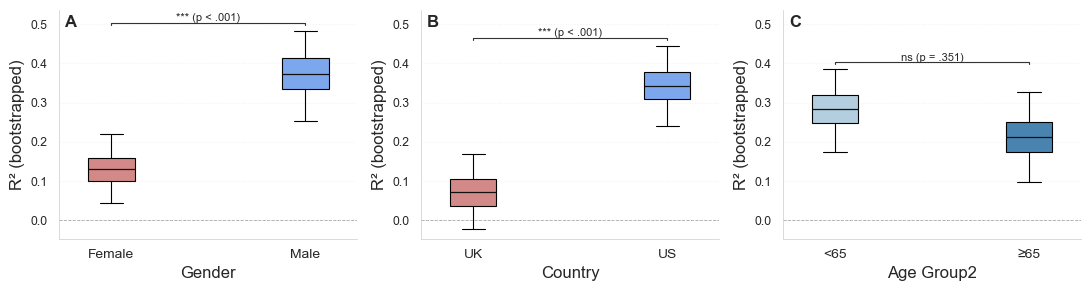

(  model         task              target AgeGroup2   r2_mean  r2_ci_low  \
 0  full  picnicScene  PictureNamingScore       <65  0.283985   0.174914   
 1  full  picnicScene  PictureNamingScore       ≥65  0.213342   0.097497   
 
    r2_ci_high  n_subjects  n_boot  
 0    0.386526         558    1000  
 1    0.326211         401    1000  ,
    group_col model         task              target    A    B  mean_diff  \
 0  AgeGroup2  full  picnicScene  PictureNamingScore  <65  ≥65   0.072986   
 
      ci_low   ci_high  p_raw  p_adj  n_boot    ci  
 0 -0.082694  0.245578  0.351  0.351    1000  0.95  )

In [4]:
# Age (2 groups): <65 vs ≥65  (keeps people who are exactly 65 in the upper bin)
age2_df, age2_levels = make_age_binary_groups(
    oof_all, age_col="Age", label_col="AgeGroup2", include_equal_65_in_upper=True
)
age2_levels = ["<65", "≥65"]

plot_bias_panels_AB_age2(
    oof_preds=oof_all,
    target=target,
    task=task,
    model=model,
    save_path=os.path.join(save_path, f"bias_panels_age2_{target}.png"),
    include_equal_65_in_upper=True
)

save_group_tables(
    age2_df, target=target, task=task, model=model,
    group_col="AgeGroup2", levels=age2_levels,
    n_boot=1000, ci=0.95, random_state=42,
    outdir=save_path
)


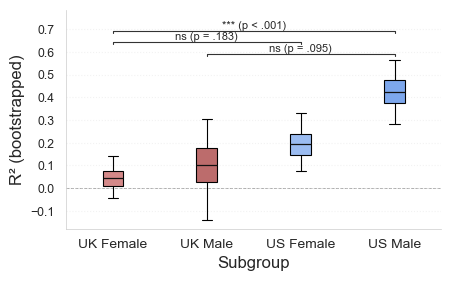

(  model         task              target CountryGender_label   r2_mean  \
 0  full  picnicScene  PictureNamingScore                uk_f  0.044065   
 1  full  picnicScene  PictureNamingScore                uk_m  0.100275   
 2  full  picnicScene  PictureNamingScore               usa_f  0.193412   
 3  full  picnicScene  PictureNamingScore               usa_m  0.425839   
 
    r2_ci_low  r2_ci_high  n_subjects  n_boot  
 0  -0.045154    0.140839         279    1000  
 1  -0.138357    0.303948         203    1000  
 2   0.076904    0.329862         309    1000  
 3   0.284320    0.563762         168    1000  ,
              group_col model         task              target      A      B  \
 2  CountryGender_label  full  picnicScene  PictureNamingScore   uk_f  usa_m   
 4  CountryGender_label  full  picnicScene  PictureNamingScore   uk_m  usa_m   
 5  CountryGender_label  full  picnicScene  PictureNamingScore  usa_f  usa_m   
 1  CountryGender_label  full  picnicScene  PictureNamingScore

In [2]:
# further inspection

cg_levels = ("uk_f", "uk_m", "usa_f", "usa_m")

plot_group_box_with_pvals(
    oof_preds=oof_all,
    target=target,
    group_col="CountryGender_label",
    levels=cg_levels,
    task=task,
    model=model,
    n_boot=1000,
    random_state=42,
    save_dir=save_path,
    box_width=0.22,
    # comparisons to annotate (if nothing: test all pairs)
    pairs_to_show=[
        ("uk_f","usa_m"),
        ("uk_f","usa_f"),
        ("uk_m","usa_m"),
    ],
    x_label="Subgroup"
)

# save bootstrap summaries and pairwise tests for the 4 groups
save_group_tables(
    oof_all, target=target, task=task, model=model,
    group_col="CountryGender_label", levels=cg_levels,
    n_boot=1000, ci=0.95, random_state=42,
    outdir=save_path
)
